In [ ]:
!git clone --recurse-submodules https://github.com/JandJane/DialogueActClassification.git

In [ ]:
!unzip DialogueActClassification/swda/swda.zip -d DialogueActClassification/swda/swda

In [ ]:
!pip install -r DialogueActClassification/requirements.txt

In [ ]:
!pip install torch transformers numpy==1.21.6

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

import sys
sys.path.append('DialogueActClassification')

from dialogue_classification.dataset_utils import load_swda_corpus_data
from dialogue_classification.train_test_split import train_set_idx, valid_set_idx, test_set_idx
from dialogue_classification.config import device

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Prepare data

In [ ]:
talks, talk_names, tag_indices, tag_occurances = load_swda_corpus_data('DialogueActClassification/swda/swda/swda')

Loading SwDA Corpus...

Found 43 different utterance tags.

Loaded SwDA Corpus.


In [ ]:
len(talks), len(tag_indices)

(1155, 43)

In [ ]:
texts, labels = [], []
for text, label in talks:
    assert len(text) == len(label)
    text = [' '.join(utterance) for utterance in text]
    texts.append(text)
    labels.append(label)

In [ ]:
train_idx = np.isin(talk_names, train_set_idx)
valid_idx = np.isin(talk_names, valid_set_idx)
test_idx = np.isin(talk_names, test_set_idx)

In [ ]:
texts, labels = np.array(texts), np.array(labels)

train_texts, train_labels = texts[train_idx], labels[train_idx]
valid_texts, valid_labels = texts[valid_idx], labels[valid_idx]
test_texts, test_labels = texts[test_idx], labels[test_idx]

<ipython-input-8-2a54f57998b8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  texts, labels = np.array(texts), np.array(labels)


In [ ]:
len(train_texts), len(valid_texts), len(test_texts)

(1003, 112, 19)

In [ ]:
# flatten
train_texts = sum(train_texts.tolist(), [])
valid_texts = sum(valid_texts.tolist(), [])
test_texts = sum(test_texts.tolist(), [])

train_labels = np.array(sum(train_labels.tolist(), []))
valid_labels = np.array(sum(valid_labels.tolist(), []))
test_labels = np.array(sum(test_labels.tolist(), []))

## Bert embeddings

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
print(tokenizer.tokenize(train_texts[0]))

['<', 'B', '##reath', '##ing', '>', '.']


In [ ]:
n_tokens = []
for text in tqdm(train_texts):
    tokens = tokenizer.tokenize(text)
    n_tokens.append(len(tokens))

100%|██████████| 193325/193325 [01:32<00:00, 2085.77it/s]


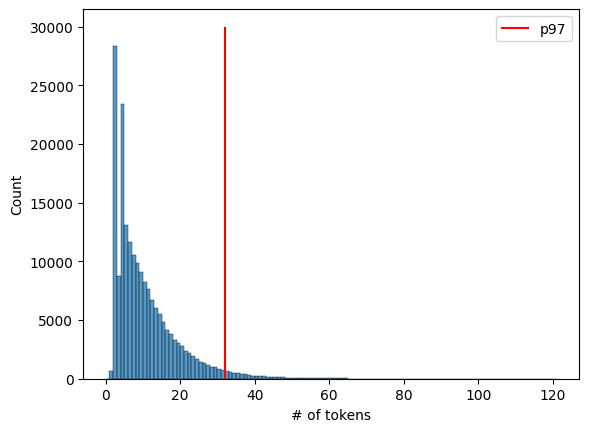

count    193325.000000
mean         10.147870
std           8.805445
min           0.000000
25%           4.000000
50%           8.000000
75%          14.000000
max         121.000000
dtype: float64

In [ ]:
n_tokens = pd.Series(n_tokens)

sns.histplot(n_tokens, binwidth=1)
plt.vlines(n_tokens.quantile(0.97), 0, 30_000, color='red', label='p97')
plt.xlabel("# of tokens")
plt.legend()
plt.show()

n_tokens.describe()

In [ ]:
n_tokens.quantile(0.97) # => max_length = 40

32.0

In [ ]:
%%time

max_length = 40

train_tokenized = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)
valid_tokenized = tokenizer(valid_texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)
test_tokenized = tokenizer(test_texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)

CPU times: user 49.8 s, sys: 421 ms, total: 50.2 s
Wall time: 57.5 s


In [ ]:
bert_model = BertModel.from_pretrained('bert-base-cased', output_hidden_states=False)
bert_model.to(device)
bert_model.eval();

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_bert_embeddings(tokenized, device=device, batch_size=4096):
  res = []
  with torch.no_grad():
    for i in tqdm(range(0, len(tokenized['input_ids']), batch_size)):
      input_ids = tokenized['input_ids'][i:i + batch_size].to(device)
      attention_mask = tokenized['attention_mask'][i:i + batch_size].to(device)
      output = bert_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
      res.append(output.detach().cpu().numpy())
  res = np.concatenate(res)
  return res

X_train = get_bert_embeddings(train_tokenized)
X_valid = get_bert_embeddings(valid_tokenized)
X_test = get_bert_embeddings(test_tokenized)

100%|██████████| 2/2 [00:10<00:00,  5.28s/it]


In [ ]:
# res.pooler_output.shape, res.last_hidden_state.shape
X_train.shape

(193325, 768)

## Train & Eval

In [ ]:
model = LGBMClassifier(n_estimators=1000, objective='multiclass', n_jobs=-1, random_state=42, learning_rate=0.02)

model.fit(
    X_train, 
    train_labels, 
    eval_metric='multi_logloss', 
    eval_set=[(X_valid, valid_labels)],
    early_stopping_rounds=50, 
    verbose=50,
)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's multi_logloss: 1.29468
[100]	valid_0's multi_logloss: 1.13219
[150]	valid_0's multi_logloss: 1.09984
[200]	valid_0's multi_logloss: 1.06644
[250]	valid_0's multi_logloss: 1.05861
[300]	valid_0's multi_logloss: 1.04902
[350]	valid_0's multi_logloss: 1.04612
[400]	valid_0's multi_logloss: 1.05063


LGBMClassifier(learning_rate=0.02, n_estimators=1000, objective='multiclass',
               random_state=42)

In [ ]:
f1_score(test_labels, model.predict(X_test), average='micro')

0.6661497563136908

In [ ]:
f1_score(test_labels, model.predict(X_test), average='macro')

0.37648967663955035

In [ ]:
f1_score(test_labels, model.predict(X_test), average='weighted')

0.6360748022214393